

UMPM
[GRAPHCUT] step1 elapsed: 1.278167724609375
[GRAPHCUT] step2 elapsed: 0.01477503776550293
[GRAPHCUT] step3 elapsed: 0.009314537048339844
[GRAPHCUT] step4 elapsed: 9.202165603637695
elapsed 10.506634950637817


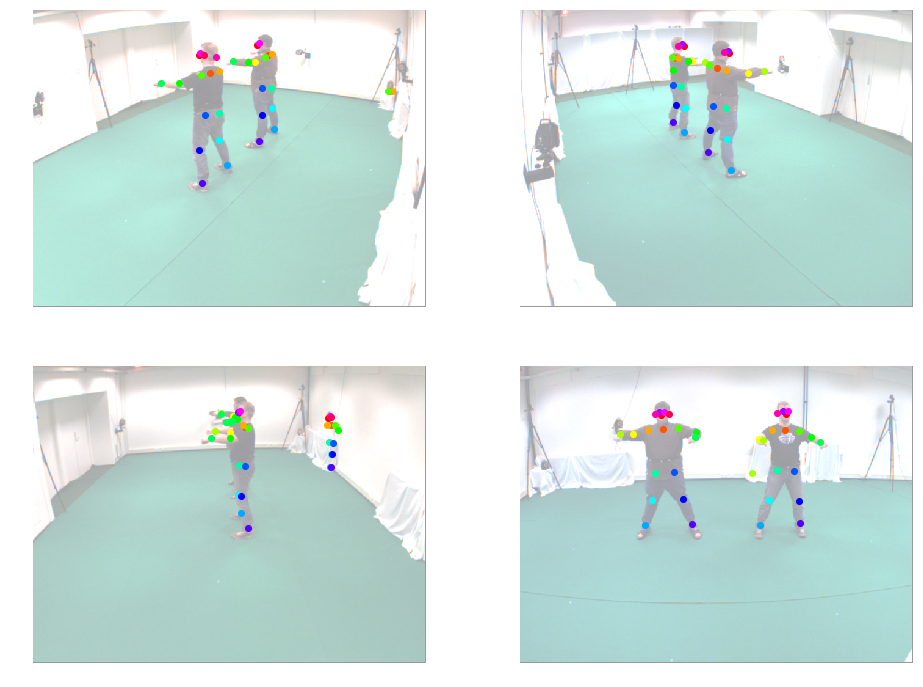

In [152]:
%matplotlib inline
# ---- settings ----
import json
Settings = json.load(open('../../settings.txt'))
print('\n')
# ------------------
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from os.path import isfile
import sys
from time import time
import cv2
import numpy as np
from os.path import join, isdir
sys.path.insert(0,'../../../easy_multi_person_pose_estimation')
sys.path.insert(0,'../../')
import mvpose.data.transform as tfm
import mvpose.geometry.geometry as gm
from mvpose.geometry import stereo
import mvpose.pose_estimation.heatmaps as mvhm
from mvpose.candidates import peaks as mvpeaks
import mvpose.pose_estimation.part_affinity_fields as mvpafs
from mvpose.data.default_limbs import  DEFAULT_LIMB_SEQ, DEFAULT_MAP_IDX
from mvpose.algorithm import graphcut
from cselect import color as cs

root = join(Settings['data_root'], 'pak')

from poseestimation import model
pe = model.PoseEstimator()


from pak.datasets.UMPM import UMPM
user = Settings['UMPM']['username']
pwd = Settings['UMPM']['password']

X, Y, Calib = tfm.get_from_umpm(root, 'p2_free_1', user, pwd)
Human_Pose_Gt = Y

# interesting frames: [340, 215, 250]
FRAME = 0

Im = np.array([X[0][FRAME], X[1][FRAME], X[2][FRAME], X[3][FRAME]])
with_gpu = False

if with_gpu:
    _start = time()
    heatmaps, pafs = pe.predict_pafs_and_heatmaps(I)
    _end = time(); print('elapsed:', _end - _start)
else:
    hm_file = '/tmp/heatmaps' + str(FRAME) + '.npy'
    paf_file = '/tmp/pafs' + str(FRAME) + '.npy'
    
    if isfile(hm_file) and isfile(paf_file):
        heatmaps = np.load(hm_file)
        pafs = np.load(paf_file)
    else:
        heatmaps = []; pafs = []
        for im in Im:
            _start = time()
            hm, paf = pe.predict_pafs_and_heatmaps(im)
            heatmaps.append(np.squeeze(hm))
            pafs.append(np.squeeze(paf))
            _end = time()
            print('elapsed:', _end - _start)
        heatmaps = np.array(heatmaps)
        pafs = np.array(pafs)
        np.save(hm_file, heatmaps)
        np.save(paf_file, pafs)
        
import mvpose.plot.limbs as pltlimbs

colors = cs.lincolor(19)/255

r = 200
_start = time()
Gr = graphcut.GraphCutSolver(heatmaps, pafs, Calib, r, debug=True)
_end = time()
print('elapsed', _end - _start)

fig = plt.figure(figsize=(16,12))

for idx, im in enumerate(Im):
    ax = fig.add_subplot(2,2,idx+1)
    ax.imshow(im, alpha=0.4)
    ax.axis('off')
    
    for jid in range(Gr.peaks2d[idx].n_joints):
        for x,y,score in Gr.peaks2d[idx][jid]:
            ax.scatter(x,y, color=colors[jid])
    
plt.show()

## Undistored peaks

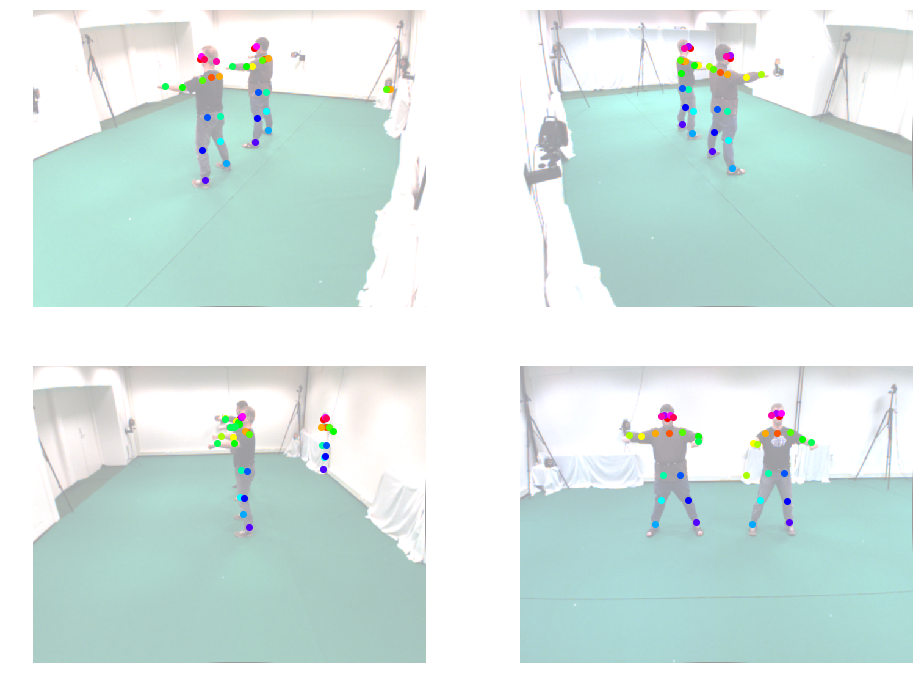

In [2]:
fig = plt.figure(figsize=(16,12))

for idx, im in enumerate(Im):
    ax = fig.add_subplot(2,2,idx+1)
    
    mapx, mapy = Gr.undistort_maps[idx]
    im = cv2.remap(im, mapx, mapy, interpolation=cv2.INTER_LINEAR)
    
    ax.imshow(im, alpha=0.4)
    ax.axis('off')
    
    for jid in range(Gr.peaks2d_undistorted[idx].n_joints):
        for x,y,score in Gr.peaks2d_undistorted[idx][jid]:
            ax.scatter(x,y, color=colors[jid])
            
plt.show()

## Re-distort 
This is needed for mapping the 3d points onto the part affinity fields

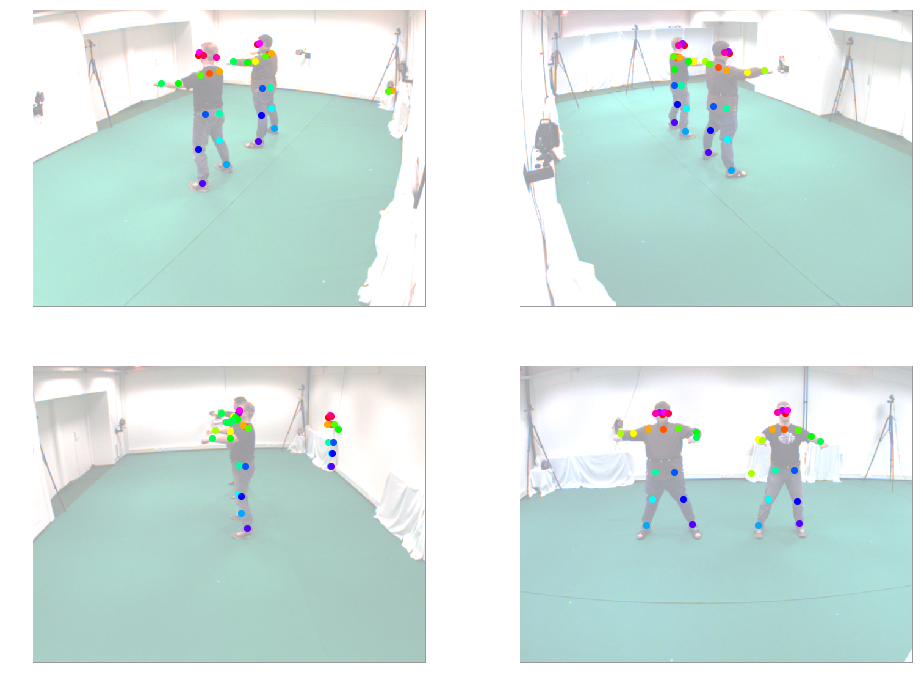

In [3]:
fig = plt.figure(figsize=(16,12))

for idx, im in enumerate(Im):
    ax = fig.add_subplot(2,2,idx+1)
    
    mapx, mapy = Gr.undistort_maps[idx]
    
    ax.imshow(im, alpha=0.4)
    ax.axis('off')
    
    for jid in range(Gr.peaks2d_undistorted[idx].n_joints):
        points = Gr.peaks2d_undistorted[idx][jid]
        points_dist = gm.distort_points(points, mapx, mapy)
        for x,y,score in points_dist:
            ax.scatter(x,y, color=colors[jid])
            
plt.show()

## Show all 3d peaks with weights

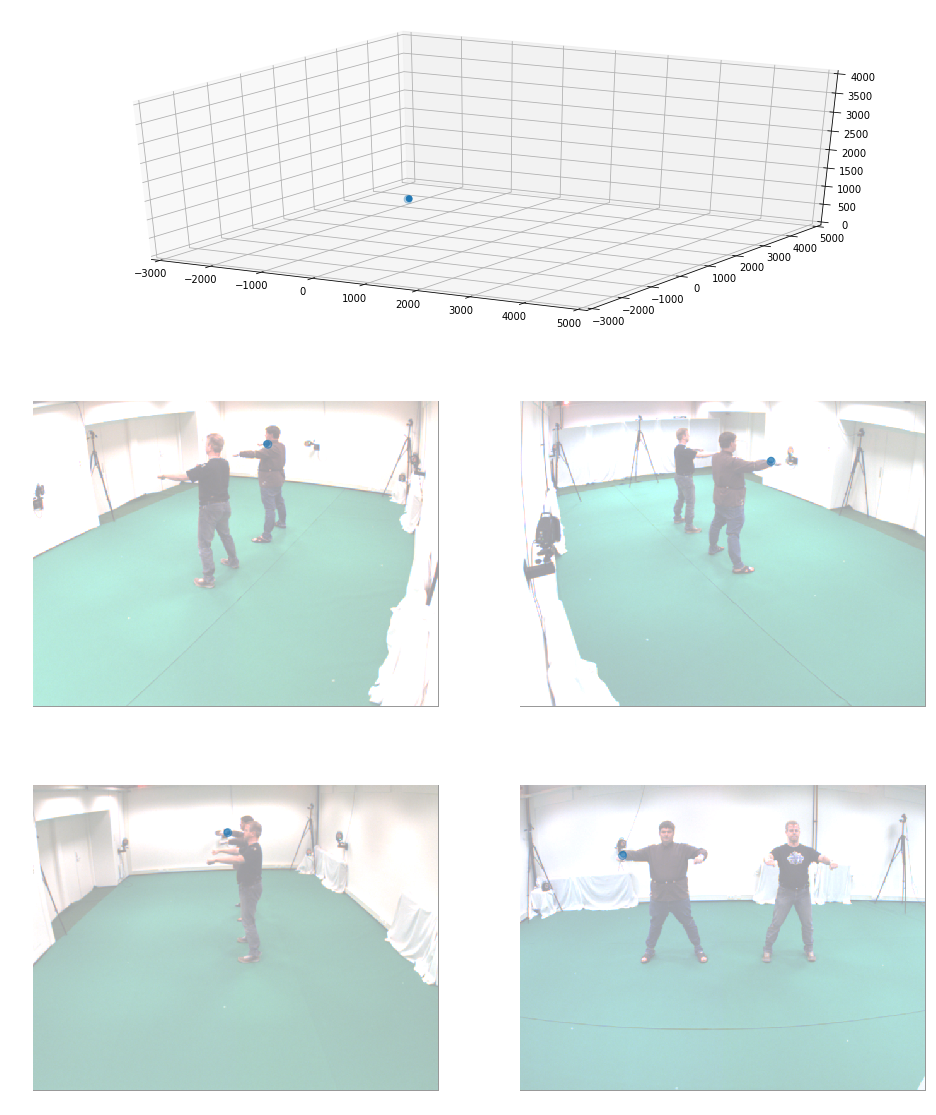

In [215]:
# 0 - Nose,  3 - relbow,  4 - rhand,  10 - rfoot,  12 - lknee,  13 - lfoot
JOINT_ID = 4

Noses = Gr.peaks3d_weighted[JOINT_ID]

fig = plt.figure(figsize=(16,20))
ax = fig.add_subplot(311, projection='3d')
ax.set_xlim([-3000, 5000])
ax.set_ylim([-3000, 5000])
ax.set_zlim([0, 4000])

X = Noses[:,0]
Y = Noses[:,1]
Z = Noses[:,2]
W = Noses[:,3] * Noses[:,4]

ax.scatter(X,Y,Z, s=W*100)

# --- reproject ---
Pts3d = Noses[:,0:3]
Pts3d = Pts3d.astype('float64')

for idx, cam in enumerate(Gr.Calib_undistorted):
    ax = fig.add_subplot(3,2,3+idx)
    ax.axis('off')
    
    im = Im[idx]
    
    ax.imshow(im, alpha=0.4)
    
    Noses2d = Gr.candidates2d[idx][JOINT_ID]
    #Noses2d = Gr.candidates2d_undistorted[idx][0]
    
    x = Noses2d[:,0]
    y = Noses2d[:,1]
    W = Noses2d[:,2] *  Noses2d[:,3]
    ax.scatter(x,y, alpha=0.5, s=W*100)
    
    
plt.show()

elapsed 0.1044151782989502


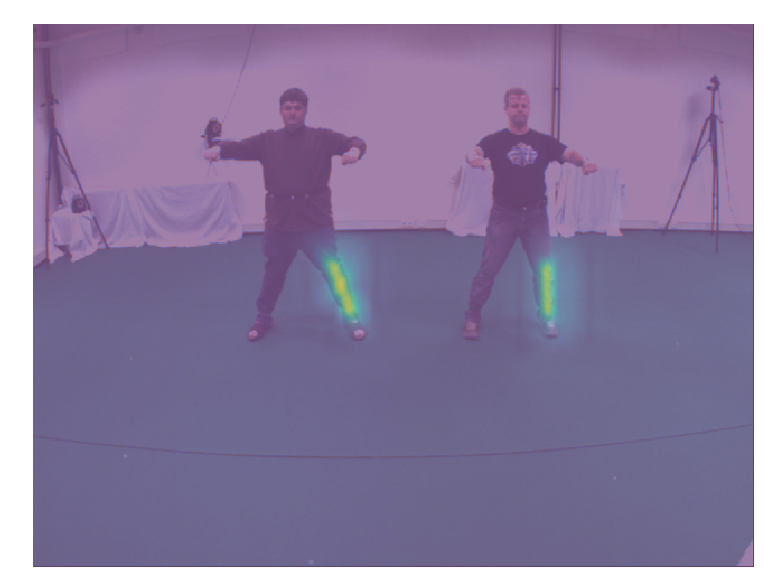

min: 2.1072178944730775e-06
max: 1.2406433026180117


In [5]:
from mvpose.data.default_limbs import  DEFAULT_LIMB_SEQ, DEFAULT_SENSIBLE_LIMB_LENGTH, DEFAULT_MAP_IDX
from mvpose.plot.limbs import draw_vector_field

assert len(DEFAULT_MAP_IDX) == len(DEFAULT_LIMB_SEQ)

LIMB_ID = 11
a,b = DEFAULT_MAP_IDX[LIMB_ID]

U = pafs[3,:,:,a]
V = pafs[3,:,:,b]

_start = time()
Vec = draw_vector_field(U, V)
_end = time()
print('elapsed', _end - _start)

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
ax.imshow(Im[3], alpha=0.5)
ax.matshow(Vec, alpha=0.5)
ax.axis('off')
plt.show()


print('min:', np.min(Vec))
print('max:', np.max(Vec))

In [6]:
#comb(4,2)

(1, 5)
minimum of W: -0.09902387102427934


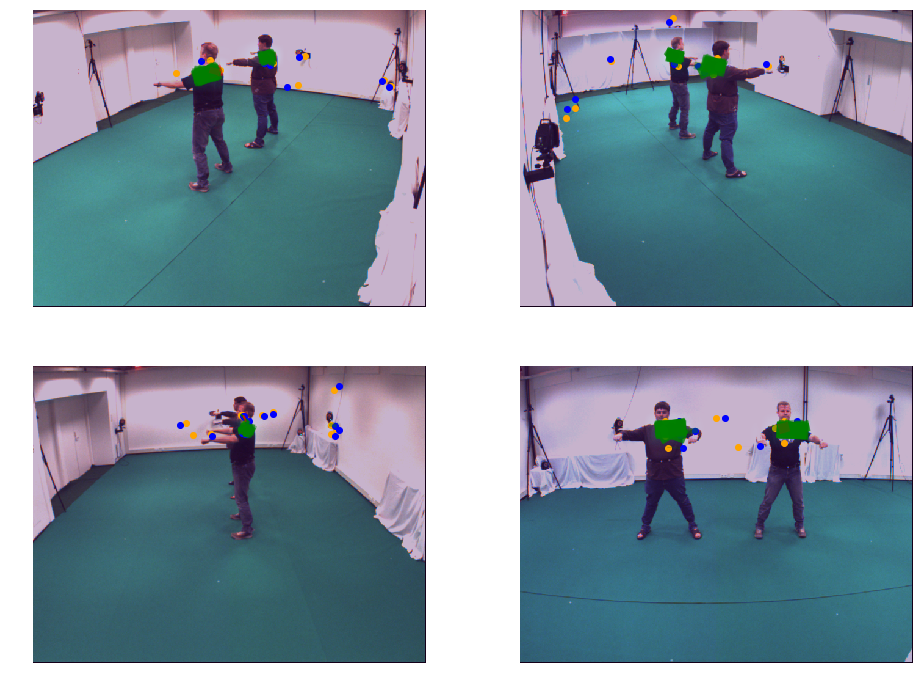

In [7]:
import numpy.linalg as la
from scipy.special import comb

cid = 2
LIMB_ID = 1

#cam = Calib[cid]

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
fig = plt.figure(figsize=(16,12))

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

a,b = DEFAULT_LIMB_SEQ[LIMB_ID]
print((a, b))
pafA, pafB = DEFAULT_MAP_IDX[LIMB_ID]
length_min, length_max = DEFAULT_SENSIBLE_LIMB_LENGTH[LIMB_ID]

candA3d = Gr.peaks3d_weighted[a]
candB3d = Gr.peaks3d_weighted[b]
nA = len(candA3d)
nB = len(candB3d)

W = np.zeros((nA, nB))

camera_normalization = comb(len(Calib), 2)

for cid, cam in enumerate(Calib):
    im = Im[cid]
    ax = fig.add_subplot(2,2,cid+1)
    ax.imshow(im)
    ax.axis('off')
    
    
    K, rvec, tvec, distCoef = gm.get_camera_parameters(cam)
    U = pafs[cid,:,:,pafA]
    V = pafs[cid,:,:,pafB]

    h,w,_ = im.shape

    ptsA2d, maskA = gm.reproject_points_to_2d(
        candA3d[:,0:3], rvec, tvec, K, w, h, distCoef=distCoef, 
        binary_mask=True)
    ptsB2d, maskB = gm.reproject_points_to_2d(
        candB3d[:,0:3], rvec, tvec, K, w, h, distCoef=distCoef, 
        binary_mask=True)


    maskA = maskA == 1
    maskB = maskB == 1
    
    for i, (ptA, ptA3d, is_A_on_screen) in enumerate(zip(ptsA2d, candA3d, maskA)):
        if is_A_on_screen:
            ax.scatter(ptA[0], ptA[1], color='orange')

    for j, (ptB, ptB3d, is_B_on_screen) in enumerate(zip(ptsB2d, candB3d, maskB)):
        if is_B_on_screen:
            ax.scatter(ptB[0], ptB[1], color='blue')

    Vec = draw_vector_field(U, V)
    ax.imshow(Vec, alpha=0.3)

    

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    ptA_candidates = []
    ptB_candidates = []
    pair_candidates = []
    
    for i, (ptA, ptA3d, is_A_on_screen) in enumerate(zip(ptsA2d, candA3d, maskA)):
        if not is_A_on_screen:
            continue
            
        for j, (ptB, ptB3d, is_B_on_screen) in enumerate(zip(ptsB2d, candB3d, maskB)):
            if not is_B_on_screen:
                continue
            distance = la.norm(ptA3d[0:3] - ptB3d[0:3])
            if length_min < distance < length_max:

                ptA_candidates.append(ptA)
                ptB_candidates.append(ptB)
                pair_candidates.append((i, j))
    
    line_int = mvpafs.calculate_line_integral_elementwise(
        np.array(ptA_candidates), np.array(ptB_candidates), U, V)
    
    assert len(line_int) == len(pair_candidates)
    line_int = np.squeeze(line_int/camera_normalization)
    
    
    IDX = 0
    for w, (i,j) in zip(line_int, pair_candidates):
        W[i,j] += w
    
        Ax, Ay = np.squeeze(ptA_candidates[IDX])
        Bx, By = np.squeeze(ptB_candidates[IDX])
        IDX += 1
            
        if w > 0:
            ax.plot([Ax, Bx], [Ay, By], color='green', linewidth=w*100, alpha=0.4)
        else:
            ax.plot([Ax, Bx], [Ay, By], color='red', linewidth=-w*100, alpha=0.4)
    
print("minimum of W:", np.min(W))

## Build graph using pafs

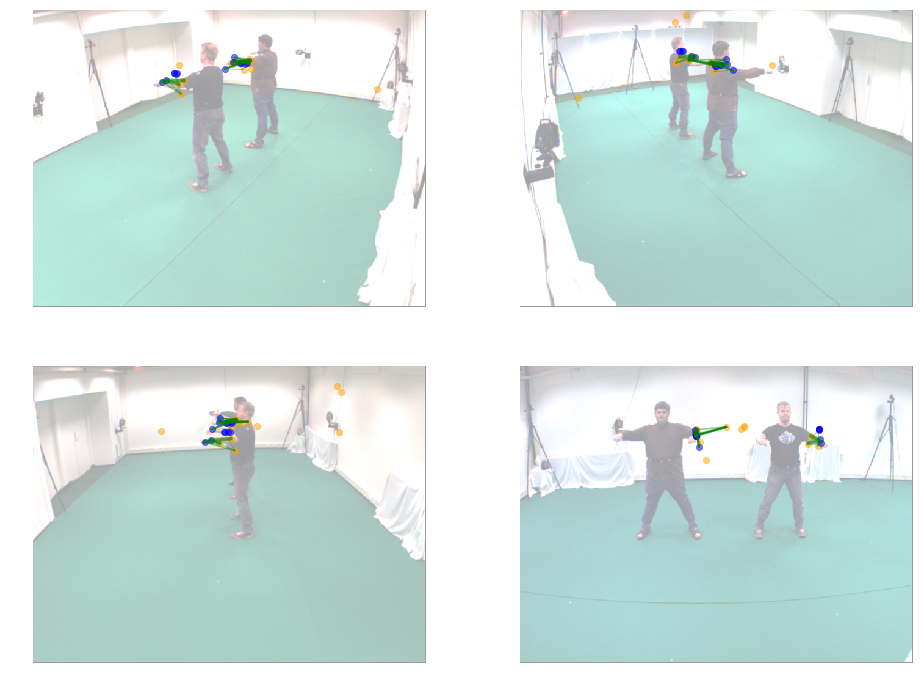

In [135]:
# take some random limb (left elbow -> hand left)
LIMB_ID = 5
a,b = DEFAULT_LIMB_SEQ[LIMB_ID]

W = Gr.limbs3d[LIMB_ID]
n,m = W.shape
candA = Gr.peaks3d_weighted[a][:,0:3]
candB = Gr.peaks3d_weighted[b][:,0:3]
assert n == len(candA) and m == len(candB)

fig = plt.figure(figsize=(16,12))

TOTAL = []

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(2,2,1+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.4)
    
    K, rvec, tvec, distCoef = gm.get_camera_parameters(cam)
    
    ptsA2d, maskA = gm.reproject_points_to_2d(candA, rvec, tvec, K, w, h, distCoef=distCoef)
    ptsB2d, maskB = gm.reproject_points_to_2d(candB, rvec, tvec, K, w, h, distCoef=distCoef)
    
    ax.scatter(ptsA2d[maskA][:,0], ptsA2d[maskA][:,1], color='orange', alpha=0.5)
    ax.scatter(ptsB2d[maskB][:,0], ptsB2d[maskB][:,1], color='blue', alpha=0.5)
    
    for _a in maskA[0]:
        for _b in maskB[0]:
            w = W[_a,_b]
            Ax,Ay = ptsA2d[_a]
            Bx,By = ptsB2d[_b]
            TOTAL.append((idx, _a, _b, w))
            if w > 0:
                ax.plot([Ax,Bx], [Ay,By], color='green', linewidth=w*10, alpha=0.4)
            else:
                ax.plot([Ax,Bx], [Ay,By], color='red', linewidth=-w*10, alpha=0.4)

TOTAL = np.array(TOTAL)

plt.show()

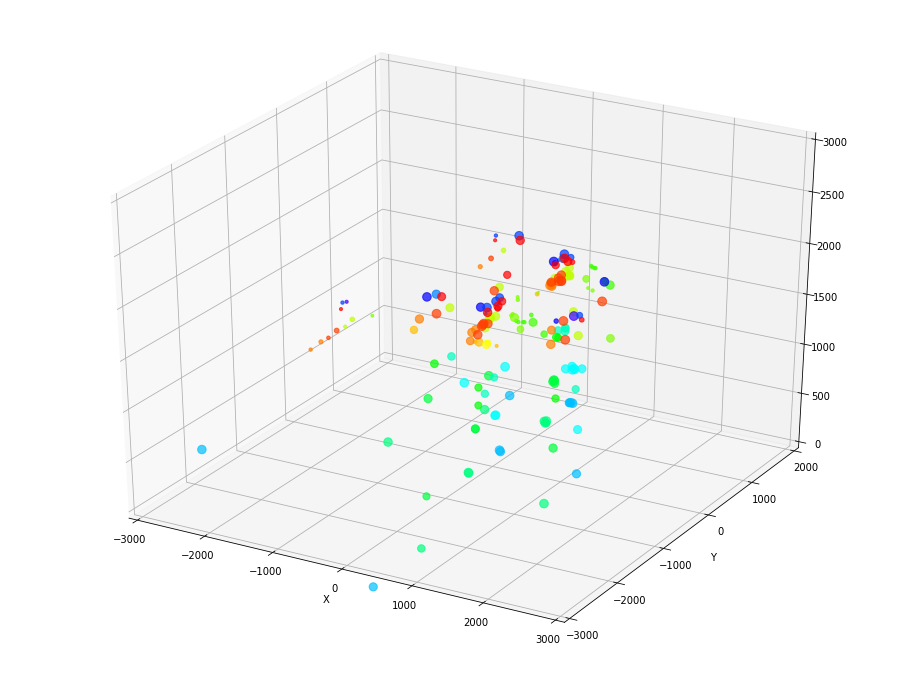

In [10]:
COLORS = cs.lincolor(25)/255
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim([-3000, 3000])
ax.set_ylim([-3000, 2000])
ax.set_zlim([0, 3000])
ax.set_xlabel('X')
ax.set_ylabel('Y')
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Points3d = Gr.peaks3d_weighted

for jid, pts3d in enumerate(Points3d):
    X = pts3d[:,0]
    Y = pts3d[:,1]
    Z = pts3d[:,2]
    W1 = pts3d[:,3]
    W2 = pts3d[:,4]
    
    ax.scatter(X,Y,Z,alpha=0.7, color=COLORS[jid], s=W1*W2*100)
        

plt.show()

## Solve the optimization problem

$$
E = \biggr(\sum_{j_1}^{J_1} \sum_{j_2}^{J_2} \lambda(j_1, j_2) \Phi(j_1, j_2) \biggr)
+ \biggr(\sum_{j_1}^{J_1} \sum_{j_2}^{J_1} \iota(j_1, j_2)\Pi(j_1, j_2) \biggr)
+ \biggr(\sum_{j_1}^{J_2} \sum_{j_2}^{J_2} \iota(j_1, j_2)\Pi(j_1, j_2) \biggr)
$$

given the following transitivity conditions:

$$\lambda(a,c) + \lambda(b,c) - 1 \leq \iota(a,b)$$
$$\lambda(a,c) + \iota(a,b) - 1 \leq \lambda(b,c)$$

In [144]:
from ortools.linear_solver import pywraplp as mip
from mvpose.geometry import geometry as gm
from mvpose.candidates.transitivity import TransitivityLookup
import networkx as nx

DEBUG = []

def cluster(points3d, limbs3d, limbSeq, sensible_limb_length, 
            radius=150, max_radius=300, iota_scale=3):
    global DEBUG
    assert len(limbs3d) == len(limbSeq)
    assert len(limbs3d) == len(sensible_limb_length)

    n_joints = len(points3d)
    
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # formulas
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    pboost_big = lambda x: np.log((x+1) / (2 * (0.5 * (-x -1)+1))) * 2
    pboost_small = lambda x: np.log(x/(1-x))
    
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    solver = mip.Solver('m', mip.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
    #solver = mip.Solver('m', mip.Solver.BOP_INTEGER_PROGRAMMING)
    
    
    D = []  # all nodes of the graph    (jid, a)
    E_j = []  # all edges on the joints (jid, a, b)
    E_l = []  # all edges on the limbs  (jid1, jid2, a, b)
        
    Nu = {}  # jid, a
    Iota = {}  # jid a b
    Lambda = {}  # jid1 jid2 a b
    
    Sum = []
    
    DEBUG_Nu = []
    DEBUG_Iota = []
    DEBUG_Lambda = []
    
    DEBUG += [DEBUG_Nu, DEBUG_Iota, DEBUG_Lambda]

    for jid, pts3d in enumerate(points3d):
        # =================
        # ~~~ handle NU ~~~
        # =================
        left = pts3d[:,3]
        right = pts3d[:,4]
        unary = np.multiply(left, right)
        n = len(unary)
        for idx in range(n):
            Nu[jid, idx] = solver.BoolVar('nu[%i,%i]' % (jid, idx))
            D.append((jid, idx))
        
        
        s = solver.Sum(
            Nu[jid, idx] * pboost_small(unary[idx]) for idx in range(n)
        )
        
        # ~~ DEBUG ~~
        for idx in range(n):
            DEBUG_Nu.append((jid, idx, pboost_small(unary[idx])))
        # ~~ DEBUG END ~~
        
        Sum.append(s)
        
        # ==========================
        # ~~~ handle intra-class ~~~
        # ==========================
        # (a, b, distance)
        distance = gm.calculate_distance_all4all(
            Points3d[jid], Points3d[jid], max_distance=max_radius,
            AB_are_the_same=True)
        As = distance[:,0].astype('int32')
        Bs = distance[:,1].astype('int32')
        
        for a, b in zip(As, Bs):
            Iota[jid, a, b] = solver.BoolVar('j[%i,%i,%i]' % (jid, a, b))
            E_j.append((jid, a, b))
        
#         s = solver.Sum(
#             Iota[jid, int(a), int(b)] * np.tanh(-d + radius) for a,b,d in distance
#         )
#         s = solver.Sum(
#             Iota[jid, int(a), int(b)] * -np.log(d) for a,b,d in distance
#         )

        func = lambda d: (-np.tanh((d-radius)/radius) * iota_scale)
        #func = lambda d: -d + 50

        s = solver.Sum(
            Iota[jid, int(a), int(b)] * func(d) for a,b,d in distance
        )
        
        # ~~ DEBUG ~~
        for a,b,d in distance:
            DEBUG_Iota.append(
                (jid, int(a), int(b), func(d)))
        # ~~ DEBUG END ~~
        
        Sum.append(s)
    
    # ==========================
    # ~~~ handle inter-class ~~~
    # ==========================
    for lid, ((jid1,jid2), (mindist, maxdist)) in \
        enumerate(zip(limbSeq, sensible_limb_length)):
        
        flip_jids = False
        if jid1 > jid2:
            # to drop duplicate edges we assume that jid1 < jid2 
            # while calculating its neighbors
            temp = jid2; jid2 = jid1; jid1 = temp
            flip_jids = True
            
        # (a, b, distance)
        ABdistance = gm.calculate_distance_all4all(
            Points3d[jid1], Points3d[jid2], maxdist,
            min_distance=mindist,
            AB_are_the_same=False)
        As = ABdistance[:,0].astype('int32')
        Bs = ABdistance[:,1].astype('int32')
        distance = ABdistance[:,2]
        
        for a,b in zip(As, Bs):
            Lambda[jid1, jid2, a, b] = solver.BoolVar(
                'l[%i,%i,%i,%i]' % (jid1, jid2, a, b))
            E_l.append((jid1, jid2, a, b))
            
        W = limbs3d[lid]
        if flip_jids:
            Scores = W[Bs,As]
        else:
            Scores = W[As,Bs]    
        
        s = solver.Sum(
            Lambda[jid1, jid2, a, b] * pboost_big(s) for a,b,s in\
            zip(As, Bs, Scores))
        
        # ~~ DEBUG ~~
        for a,b,s in zip(As, Bs, Scores):
            DEBUG_Lambda.append((jid1, jid2, a, b, pboost_big(s)))
        # ~~ DEBUG END ~~
        
        Sum.append(s)
    
#    =========================
#    ~~~ handle conditions ~~~
#    =========================

    Get_Iota = lambda jid, a, b: Iota[jid, min(a, b), max(a, b)]
    Get_Lambda = lambda jid1, jid2, a, b: Lambda[jid1, jid2, a, b] \
        if jid1 < jid2 else Lambda[jid2, jid1, b, a]

    for jid1, jid2, a, b in E_l:
        solver.Add(
            Lambda[jid1, jid2, a, b] * 2 <= Nu[jid1, a] + Nu[jid2, b])
    
    for jid, a, b in E_j:
        solver.Add(
            Iota[jid, a, b] * 2 <= Nu[jid, a] + Nu[jid, b])
    
    
    transitivity_lookup = TransitivityLookup(D, E_l, E_j)

    Intra = []  #  [ (jid, a, b, c), ...]
    Inter = []  # [ (jid1, a, b, jid2, c), ...]
    Intra_choice = []  # [ (jid, a, b, c), ...]
    Inter_choice = []  # [ (jid1, a, jid2, b, jid3, c), ...]
    
    for q in D:
        intra, intra_choice, inter, inter_choice =\
            transitivity_lookup.query_with_choice(*q)
        Intra += intra
        Inter += inter
        Intra_choice += intra_choice
        Inter_choice += inter_choice
    
    assert len(Inter_choice) == len(set(Inter_choice))
    assert len(Intra_choice) == len(set(Intra_choice))
    
    for jid, a, b, c in Intra:
        solver.Add(
            Get_Iota(jid, a, b) + Get_Iota(jid, a, c) - 1 <= Get_Iota(jid, b, c))
#         solver.Add(
#             Get_Iota(jid, a, c) + Get_Iota(jid, b, c) - 1 <= Get_Iota(jid, a, b))
#         solver.Add(
#             Get_Iota(jid, a, b) + Get_Iota(jid, a, c) - 1 <= Get_Iota(jid, b, c))

    for jid1, a, b, jid2, c in Inter:
        solver.Add(
            Get_Lambda(jid1, jid2, a, c) + Get_Iota(jid1, a, b) - 1 <=\
            Get_Lambda(jid1, jid2, b, c))
        solver.Add(
            Get_Lambda(jid1, jid2, b, c) + Get_Iota(jid1, a, b) - 1 <=\
            Get_Lambda(jid1, jid2, a, c))
        solver.Add(
            Get_Lambda(jid1, jid2, a, c) + Get_Lambda(jid1, jid2, b, c) - 1 <=\
            Get_Iota(jid1, a, b))
    
    for jid, a, b, c in Intra_choice:  # either take { ab OR ac }
        solver.Add(
            Get_Iota(jid, a, b) + Get_Iota(jid, a, c) <= 1
        )
    
    for jid1, a, jid2, b, jid3, c in Inter_choice:  # { ab OR ac }
        if jid1 == jid2:
            assert jid3 != jid1
            # if  [a]---[b]
            #     |
            #    (c)
            solver.Add(
                Get_Iota(jid1, a, b) + Get_Lambda(jid1, jid3, a, c) <= 1
            )
        elif jid2 == jid3:
            # if  [a]
            #     |   \
            #    (b)   (c)
            solver.Add(
                Get_Lambda(jid1, jid2, a, b) + Get_Lambda(jid1, jid3, a, c) <= 1
            )
        elif jid1 == jid3:
            # if  [a]---[c]
            #     |
            #    (b)
            solver.Add(
                Get_Lambda(jid1, jid2, a, b) + Get_Iota(jid1, a, c) <= 1
            )

    
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~
    print("D", len(D))
    print("E_j", len(E_j))
    print("E_l", len(E_l))
    print("Sums:", len(Sum))
    print("intra:", len(Intra))
    print("inter:", len(Inter))
    
    # ~~~ execute optimization ~~~
    solver.Maximize(sum(Sum))
    RESULT = solver.Solve()
    print("Time = ", solver.WallTime(), " ms")
    print("result:", RESULT)
    print('\nTotal cost:', solver.Objective().Value())
    
    
    # ~~~ extract 3d points ~~~
    
    #valid_3d_points = [None] * n_joints
    valid_3d_points = set()
    for (jid, idx), v in Nu.items():
        if v.solution_value() > 0:
            #valid_3d_points[jid].append(points3d[jid][idx])
            valid_3d_points.add((jid, idx))
            
    # TODO: use the graph from transitivity_lookup
    graph = nx.Graph()
    
    assert len(transitivity_lookup.lookup) == len(Nu)
    
    for (jid1, jid2, a, b), v in Lambda.items():
        if v.solution_value() > 0:
            assert (jid1, a) in valid_3d_points and (jid2, b) in valid_3d_points
            candA = transitivity_lookup.lookup[jid1, a]
            candB = transitivity_lookup.lookup[jid2, b]
            graph.add_edge(candA, candB)
        
    for (jid1, a, b), v in Iota.items():
        if v.solution_value() > 0:
            assert (jid1, a) in valid_3d_points and (jid1, b) in valid_3d_points
            candA = transitivity_lookup.lookup[jid1, a]
            candB = transitivity_lookup.lookup[jid1, b]
            graph.add_edge(candA, candB)
            
    # ~~~ get the persons ~~~
    
    persons = []
    
    for comp in nx.connected_components(graph):
        person = [None] * n_joints
        for node in comp:
            jid, idx = transitivity_lookup.reverse_lookup[node]
            if person[jid] is None:
                person[jid] = []
            person[jid].append(points3d[jid][idx])
        persons.append(person)
    
    for pid in range(len(persons)):
        for jid in range(n_joints):
            if persons[pid][jid] is not None:
                persons[pid][jid] = np.array(persons[pid][jid])
    
    return persons
    
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# testing
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Points3d = Gr.peaks3d_weighted
Limbs3d = Gr.limbs3d

_start = time()
persons = cluster(Points3d, Limbs3d, DEFAULT_LIMB_SEQ, DEFAULT_SENSIBLE_LIMB_LENGTH)
_end = time()
print('elapsed', _end - _start)

print("\n#Persons:", len(persons))

D 183
E_j 183
E_l 480
Sums: 55
intra: 498
inter: 1312
Time =  707  ms
result: 0

Total cost: 250.9236563930186
elapsed 0.7125635147094727

#Persons: 28


(2437, 28, 4)


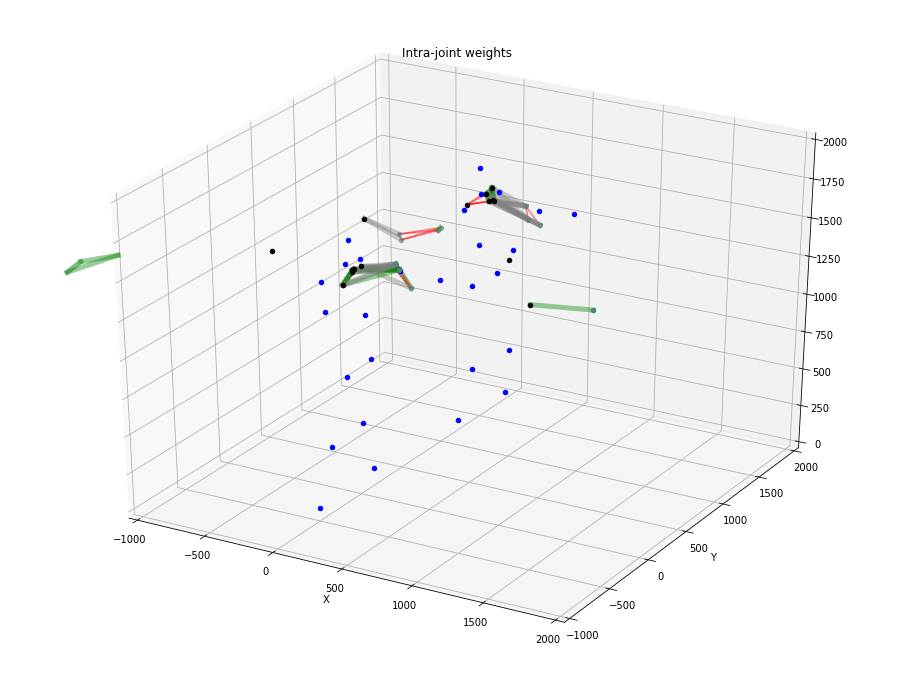

In [188]:
from random import shuffle

DEBUG_Nu = np.array(DEBUG[0])
DEBUG_Iota = np.array(DEBUG[1])
DEBUG_Lambda = np.array(DEBUG[2])

W1 = sorted(DEBUG_Nu[:,2])
W2 = sorted(DEBUG_Iota[:,3])
W3 = sorted(DEBUG_Lambda[:,4])

TOTAL = 19
COLORS = [(1/TOTAL*i,1/TOTAL*i,1/TOTAL*i) for i in range(TOTAL)]
shuffle(COLORS)

#COLORS = cs.lincolor(25)/255


fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Intra-joint weights")
ax.set_xlim([-1000, 2000])
ax.set_ylim([-1000, 2000])
ax.set_zlim([0, 2000])
ax.set_xlabel('X')
ax.set_ylabel('Y')
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

A_p = []
B_p = []

def plot_limb(ax, LIMB_ID):
    JOINT_A, JOINT_B = DEFAULT_LIMB_SEQ[LIMB_ID]

    Points3d = Gr.peaks3d_weighted
    
    Disabled = set()

    for jid, idx, score in DEBUG_Nu:
        jid = int(jid)
        if jid == JOINT_A or jid == JOINT_B:
            color = (0, 0, 0) if jid == JOINT_A else (0.3, 0.5, 0.5)
            idx = int(idx)
            x,y,z,_,_,_,_ = Points3d[jid][idx]
            
            if x > 2000 or x < -1000 or y > 2000 or y < -2000 or z > 2000 or z < 0:
                continue
            if jid == JOINT_A:
                A_p.append((x,y,z,score))
            else:
                B_p.append((x,y,z,score))
            
            if score > 0:
                ax.scatter(x,y,z, color=color, alpha=1)
            else:
                ax.scatter(x,y,z, color=color, alpha=0.4)
                Disabled.add((jid, idx))


    for jid, a, b, score in DEBUG_Iota:
        jid = int(jid)
        a = int(a)
        b = int(b)
        if jid == JOINT_A or jid == JOINT_B:
            x1,y1,z1,_,_,_,_ = Points3d[jid][a]
            x2,y2,z2,_,_,_,_ = Points3d[jid][b]
            
            if (jid, a) in Disabled or (jid, b) in Disabled:
                pass

            if score > 0:
                ax.plot([x1, x2], [y1, y2], [z1, z2], color='green', linewidth=5, alpha=0.5)
            else:
                ax.plot([x1, x2], [y1, y2], [z1, z2], color='red', alpha=0.5)


    for jid1, jid2, a, b, score in DEBUG_Lambda:
        if jid1 == JOINT_A and jid2 == JOINT_B:
            color = 'green'
            if (jid1, a) in Disabled or (jid2, b) in Disabled:
                color = 'gray'
                
            x1,y1,z1,_,_,_,_ = Points3d[int(jid1)][int(a)]
            x2,y2,z2,_,_,_,_ = Points3d[int(jid2)][int(b)]
            ax.plot([x1, x2], [y1, y2], [z1, z2], color=color, linewidth=5, alpha=0.4)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

print(Human_Pose_Gt.shape)

# for i in range(19):
#     plot_limb(ax, i)
plot_limb(ax, 4)

for x,y,z,_ in Human_Pose_Gt[0]:
    ax.scatter(x,y,z,color='blue')

A_p = np.array(A_p)
B_p = np.array(B_p)

plt.show()

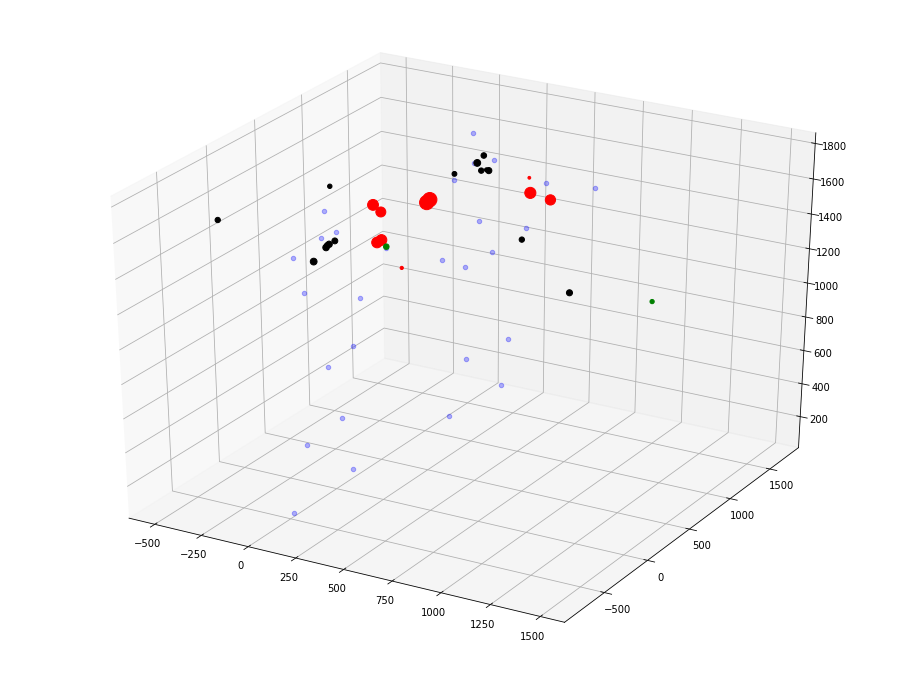

In [212]:
W1 = A_p[:,3]
W2 = B_p[:,3]



fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(A_p[:,0], A_p[:,1], A_p[:,2], color='black', alpha=1, s=W1*50)
#ax.scatter(B_p[:,0], B_p[:,1], B_p[:,2], color='gray', alpha=1, s=W2*10)

pos_mask = W2 > 0
neg_mask = W2 < 0
ax.scatter(B_p[pos_mask,0], B_p[pos_mask,1], B_p[pos_mask,2], color='green', alpha=1, s=W2[pos_mask]*50)
ax.scatter(B_p[neg_mask,0], B_p[neg_mask,1], B_p[neg_mask,2], color='red', alpha=1, s=-W2[neg_mask]*50)

for x,y,z,_ in Human_Pose_Gt[0]:
    ax.scatter(x,y,z,color='blue', alpha=0.3)

plt.show()

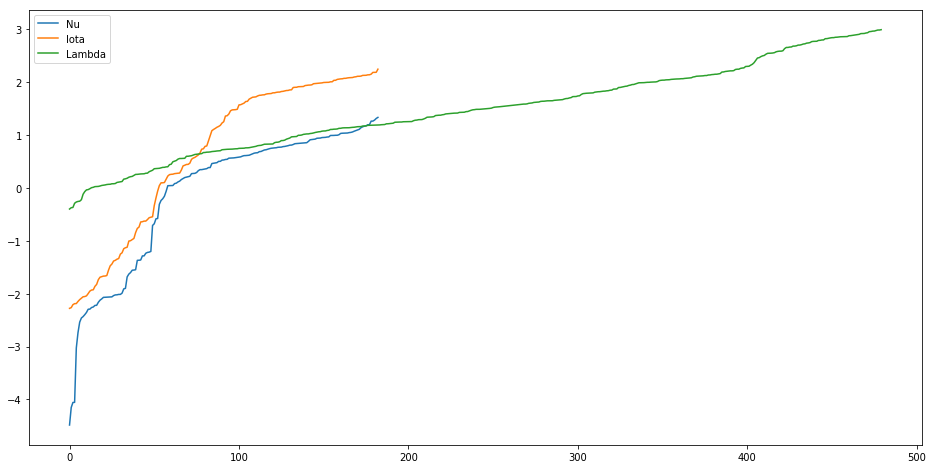

In [146]:
DEBUG_Nu = np.array(DEBUG[0])
DEBUG_Iota = np.array(DEBUG[1])
DEBUG_Lambda = np.array(DEBUG[2])

# W1 = sorted(DEBUG_Nu[:,2])
W2 = sorted(DEBUG_Iota[:,3])
W3 = sorted(DEBUG_Lambda[:,4])

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
ax.plot(range(len(W1)), W1, label='Nu')
ax.plot(range(len(W2)), W2, label='Iota')
ax.plot(range(len(W3)), W3, label='Lambda')

plt.legend()
plt.show()

In [128]:
persons[0]

[array([[ 2.62083212e+02, -2.87664943e+02,  1.66004921e+03,
          7.44152412e-01,  4.43483695e-01,  9.15593719e+01,
          6.04235082e+00],
        [ 2.70932082e+02, -2.95953921e+02,  1.68570215e+03,
          7.44152412e-01,  9.13409084e-01,  1.16983068e+01,
          7.66118503e+00]]),
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

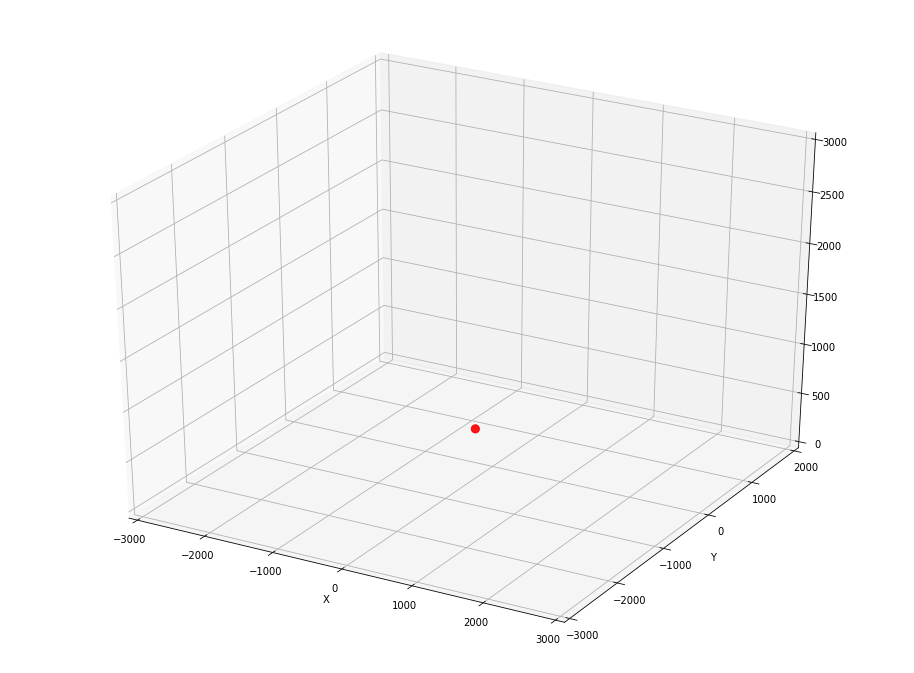

In [43]:
COLORS = cs.lincolor(max(1, len(persons) + 1))/255
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim([-3000, 3000])
ax.set_ylim([-3000, 2000])
ax.set_zlim([0, 3000])
ax.set_xlabel('X')
ax.set_ylabel('Y')
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Points3d = Gr.peaks3d_weighted


for pid, person in enumerate(persons):
    for jid, pts3d in enumerate(person):
        if pts3d is not None:
            X = pts3d[:,0]
            Y = pts3d[:,1]
            Z = pts3d[:,2]
            W1 = pts3d[:,3]
            W2 = pts3d[:,4]
    
            ax.scatter(X,Y,Z,alpha=0.7, color=COLORS[pid], s=W1*W2*100)
        
plt.show()